# Goals

The purpose of this analysis is to provide a method for early identification of students at risk of failing. This is vital for any learning platforms, especially online ones. The data used is the [Open University Learning Analytics dataset (OULAD)](https://analyse.kmi.open.ac.uk/open_dataset).  

# Data Exploration

In [1]:
# import

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_columns', None)

In [2]:
# csv to pd frame 

csv_path = '../input/student-demographics-online-education-dataoulad/'
data_dicts = {csv_name[:-4]: pd.read_csv(csv_path+csv_name) for csv_name in os.listdir(csv_path)}

First let's take a look at each dataset separately. 

## courses.csv


In [3]:
data_dicts['courses'].groupby(['code_module','code_presentation']).agg(['min','max'])

module_presentation_length     
                                                     min  max
code_module code_presentation                                
AAA         2013J                                    268  268
            2014J                                    269  269
BBB         2013B                                    240  240
            2013J                                    268  268
            2014B                                    234  234
            2014J                                    262  262
CCC         2014B                                    241  241
            2014J                                    269  269
DDD         2013B                                    240  240
            2013J                                    261  261
            2014B                                    241  241
            2014J                                    262  262
EEE         2013J                                    268  268
            2014B                                    241  241
            2014J                                    269  269
FFF         2013B                                    240  240
            2013J                                    268  268
            2014B                                    241  241
            2014J                                    269  269
GGG         2013J                                    261  261
            2014B                                    241  241
            2014J                                    269  269

According to the data's documentation, there are 8 courses (modules) recorded, from A to G (AAA in dataset, henceforth shortened to A). There are 2 semesters recorded, February (B) and October (J). February semesters are typically 20 days shorter then October ones. Some courses (C,E,G) don't have data for both 2013 and 2014. 

## assessments.csv

In [4]:
df = data_dicts['assessments']
df

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0
...,...,...,...,...,...,...
201,GGG,2014J,37443,CMA,229.0,0.0
202,GGG,2014J,37435,TMA,61.0,0.0
203,GGG,2014J,37436,TMA,124.0,0.0
204,GGG,2014J,37437,TMA,173.0,0.0


In [5]:

df.drop(['date','weight'],axis = 1).groupby(['code_module','assessment_type','code_presentation']).count()


id_assessment
code_module assessment_type code_presentation               
AAA         Exam            2013J                          1
                            2014J                          1
            TMA             2013J                          5
                            2014J                          5
BBB         CMA             2013B                          5
                            2013J                          5
                            2014B                          5
            Exam            2013B                          1
                            2013J                          1
                            2014B                          1
                            2014J                          1
            TMA             2013B                          6
                            2013J                          6
                            2014B                          6
                            2014J                          5
CCC         CMA             2014B                          4
                            2014J                          4
            Exam            2014B                          2
                            2014J                          2
            TMA             2014B                          4
                            2014J                          4
DDD         CMA             2013B                          7
            Exam            2013B                          1
                            2013J                          1
                            2014B                          1
                            2014J                          1
            TMA             2013B                          6
                            2013J                          6
                            2014B                          6
                            2014J                          6
EEE         Exam            2013J                          1
                            2014B                          1
                            2014J                          1
            TMA             2013J                          4
                            2014B                          4
                            2014J                          4
FFF         CMA             2013B                          7
                            2013J                          7
                            2014B                          7
                            2014J                          7
            Exam            2013B                          1
                            2013J                          1
                            2014B                          1
                            2014J                          1
            TMA             2013B                          5
                            2013J                          5
                            2014B                          5
                            2014J                          5
GGG         CMA             2013J                          6
                            2014B                          6
                            2014J                          6
            Exam            2013J                          1
                            2014B                          1
                            2014J                          1
            TMA             2013J                          3
                            2014B                          3
                            2014J                          3

Course C have 2 final exams. Course A doesn't have any Computer Marked Assessment (CMA). Each course has at least 3 TMAs.

In [6]:
df.drop(['id_assessment'],axis = 1).groupby(['code_module','assessment_type','code_presentation']).agg(['min','max'])

date        weight       
                                                 min    max    min    max
code_module assessment_type code_presentation                            
AAA         Exam            2013J                NaN    NaN  100.0  100.0
                            2014J                NaN    NaN  100.0  100.0
            TMA             2013J               19.0  215.0   10.0   30.0
                            2014J               19.0  215.0   10.0   30.0
BBB         CMA             2013B               54.0  187.0    1.0    1.0
                            2013J               54.0  208.0    1.0    1.0
                            2014B               47.0  194.0    1.0    1.0
            Exam            2013B                NaN    NaN  100.0  100.0
                            2013J                NaN    NaN  100.0  100.0
                            2014B                NaN    NaN  100.0  100.0
                            2014J                NaN    NaN  100.0  100.0
            TMA             2013B               19.0  187.0    5.0   18.0
                            2013J               19.0  208.0    5.0   18.0
                            2014B               12.0  194.0    5.0   18.0
                            2014J               19.0  201.0    0.0   35.0
CCC         CMA             2014B               18.0  207.0    2.0    8.0
                            2014J               18.0  214.0    2.0    8.0
            Exam            2014B                NaN    NaN  100.0  100.0
                            2014J                NaN    NaN  100.0  100.0
            TMA             2014B               32.0  200.0    9.0   22.0
                            2014J               32.0  207.0    9.0   22.0
DDD         CMA             2013B               23.0  206.0    2.0    6.0
            Exam            2013B              240.0  240.0  100.0  100.0
                            2013J              261.0  261.0  100.0  100.0
                            2014B              241.0  241.0  100.0  100.0
                            2014J                NaN    NaN  100.0  100.0
            TMA             2013B               25.0  200.0    7.5   15.0
                            2013J               25.0  207.0   10.0   20.0
                            2014B               25.0  200.0   10.0   20.0
                            2014J               20.0  195.0    5.0   25.0
EEE         Exam            2013J              235.0  235.0  100.0  100.0
                            2014B              228.0  228.0  100.0  100.0
                            2014J              235.0  235.0  100.0  100.0
            TMA             2013J               33.0  159.0   16.0   28.0
                            2014B               33.0  152.0   16.0   28.0
                            2014J               33.0  166.0   16.0   28.0
FFF         CMA             2013B              222.0  222.0    0.0    0.0
                            2013J              236.0  236.0    0.0    0.0
                            2014B              227.0  227.0    0.0    0.0
                            2014J              241.0  241.0    0.0    0.0
            Exam            2013B              222.0  222.0  100.0  100.0
                            2013J              236.0  236.0  100.0  100.0
                            2014B              227.0  227.0  100.0  100.0
                            2014J              241.0  241.0  100.0  100.0
            TMA             2013B               19.0  166.0   12.5   25.0
                            2013J               19.0  173.0   12.5   25.0
                            2014B               24.0  171.0   12.5   25.0
                            2014J               24.0  199.0   12.5   25.0
GGG         CMA             2013J              229.0  229.0    0.0    0.0
                            2014B              222.0  222.0    0.0    0.0
                            2014J              229.0  229.0    0.0    0.0
            Exam            2013J              229.0

According to data's documentation, exams have weight 100, and all the other assignments have weights adding up to 100. However, this is not true for all courses. In course G, only exams have weight. Additionally, course G has all CMAs on the same date. Course G is also abnormal in term of assignment date: all the other courses have first assignment within the first 30 days, but first assignment for course G is on day 61. Finally, final exam dates are missing, but this can be collected from the `courses.csv` dataset. 

## vle.csv

In [7]:
df = data_dicts['vle']
df
#sum(df['week_from'].isnull())/df.shape[0]

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN
...,...,...,...,...,...,...
6359,897063,GGG,2014J,resource,NaN,NaN
6360,897109,GGG,2014J,resource,NaN,NaN
6361,896965,GGG,2014J,oucontent,NaN,NaN
6362,897060,GGG,2014J,resource,NaN,NaN


`week_from` and `week_to` tell us the timeframe certain contents are supposed to be used. Unfortunately, over 82% of this content is missing from the dataset.

## studentInfo.csv

In [8]:
df = data_dicts['studentInfo']
df


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn


In [9]:
print('precentage of missing entries per column:')
df.isnull().sum()/len(df)*100


precentage of missing entries per column:


code_module             0.000000
code_presentation       0.000000
id_student              0.000000
gender                  0.000000
region                  0.000000
highest_education       0.000000
imd_band                3.408707
age_band                0.000000
num_of_prev_attempts    0.000000
studied_credits         0.000000
disability              0.000000
final_result            0.000000
dtype: float64

There are 1000 observations with `imd_band` (Index of Multiple Depravation, an index for living condition) missing. Something we might want to consider when building model later. 

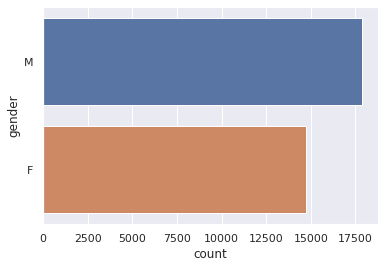

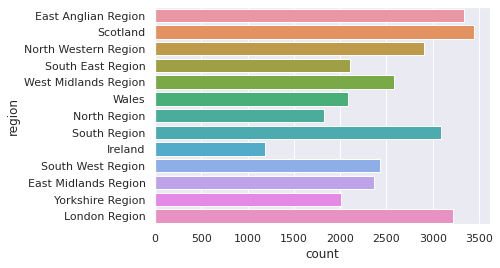

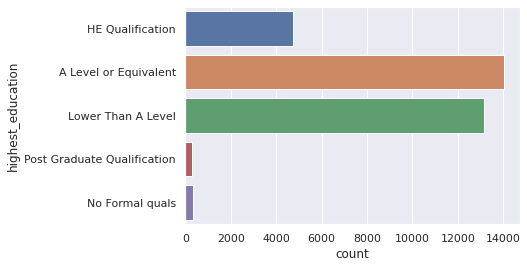

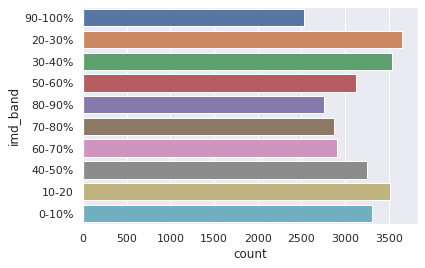

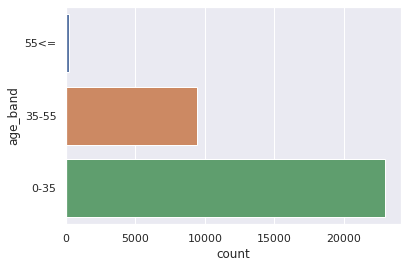

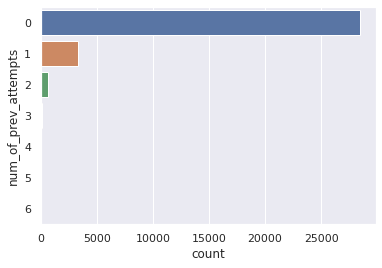

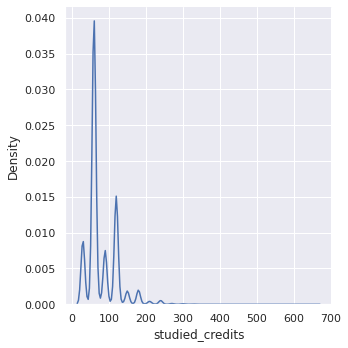

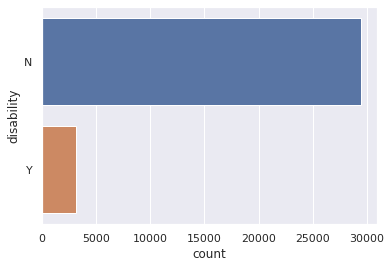

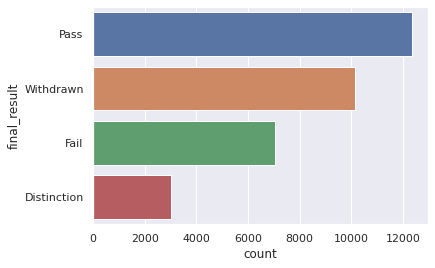

In [10]:
sns.set_theme(style="darkgrid")
for i, column in enumerate(df.columns):
    if i>2 and i != 9:
        sns.countplot(y = column, data = df)
        plt.show()
    elif i == 9: 
        sns.displot(x = column, data = df, kind="kde")
        plt.show()

Certain features such as `studied_credits`, `num_of_prev_attempts`, `age_band`, `highest_education` contain some extreme observations. It's not really a problem for our analysis

## studentRegistration.csv

In [11]:
df = data_dicts['studentRegistration']
df.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


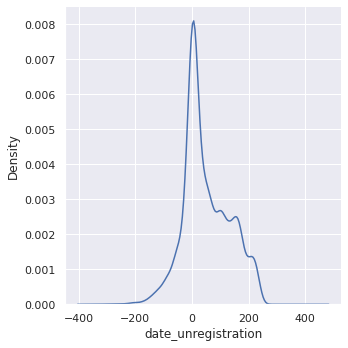

In [12]:
sns.displot(x = 'date_unregistration', data = df, kind="kde")
plt.show()

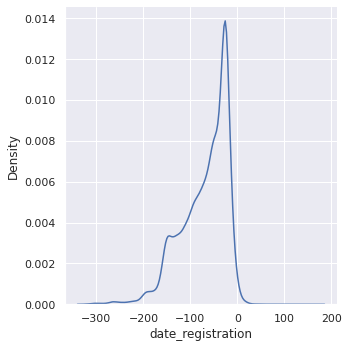

In [13]:
sns.displot(x = 'date_registration', data = df, kind="kde")
plt.show()

In [14]:
df['date_registration'].quantile(0.99),df['date_registration'].quantile(0.999),df['date_registration'].max()

(-2.0, 18.453000000004977, 167.0)

From the plot, we can see that there are a decent amount of students who withdrew from a course before it started. We will remove these students from our dataset later, since we don't have any academic performance data for them.Also,it is not easy to register in the course after its beginnig.99% percent of the students registerd before its beginning.


## studentAssessment.csv

In [15]:
df = data_dicts['studentAssessment']
df.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [16]:
print('Number of missing entries per column:')
df.isnull().sum()/len(df)*100

Number of missing entries per column:


id_assessment     0.000000
id_student        0.000000
date_submitted    0.000000
is_banked         0.000000
score             0.099476
dtype: float64

In [17]:
df.describe()

,id_assessment,id_student,date_submitted,is_banked,score
count,173912.000000,1.739120e+05,173912.000000,173912.000000,173739.000000
mean,26553.803556,7.051507e+05,116.032942,0.010977,75.799573
std,8829.784254,5.523952e+05,71.484148,0.104194,18.798107
min,1752.000000,6.516000e+03,-11.000000,0.000000,0.000000
25%,15022.000000,5.044290e+05,51.000000,0.000000,65.000000
50%,25359.000000,5.852080e+05,116.000000,0.000000,80.000000
75%,34883.000000,6.344980e+05,173.000000,0.000000,90.000000
max,37443.000000,2.698588e+06,608.000000,1.000000,100.000000


According to the data's documentation, score ranges from 0 to 100. Score lower than 40 is interpreted as a Fail. If the student does not submit the assessment, no result is recorded. Most of the missing scores are from final exams, which does not impact our analysis, since we are only concern with students' performance early in the semester.

# Prepping the Data for Analysis

In [18]:
# function for merging 2 pandas dataframes

def inner_merge(left_df,right_df,right_cols,on_cols):
    right_df = right_df[right_cols]
    left_df = left_df.merge(right_df, on = on_cols)
    return left_df.drop_duplicates()

We want to predict a student's final result based on their early performance. By performance, we mean 2 things: academic performance, measured via the students' scores, and academic engagement, measured via the number of times the students click on course content. The three variables below control how many days into a semester we want to include for our analysis.  

In [19]:
score_deadline = 120
click_deadline = 120
withdraw_deadline = 120

Below we have a function that creates a dataset that contains each student's average assignment score within the first `score_deadline` days. Another function to create a dataset that contains each student's average number of clicks for each resource category within the first `click_deadline` days. Then a function to merge the two datasets together, as well as remove students who withdrew before `withdraw_deadline`. Since our analysis only concerns with Pass/Fail, we merge Distinction final results into Pass, and merge Withdrawn into Fail. The idea is that after a certain amount of time, the only people who withdraw are the people who are concerned with their performance, and are less likely to withdraw due to non-academic related reasons. 

In [20]:
# score data

def create_score_df(score_deadline):

    df1 = data_dicts['assessments']
    df2 = data_dicts['studentAssessment']

    score_df = inner_merge(df1,
                           df2,
                           df2.columns,
                           ['id_assessment'],
                          )

    score_df = score_df[score_df['date'] < score_deadline]

    score_df = score_df[score_df['assessment_type'] != 'Exam']

    score_df = score_df.dropna(subset = ['score']) 

    score_df.isnull().sum()

    score_df['assessment_type'].value_counts()

    score_df = score_df.groupby(['code_module', 'code_presentation', 'id_student']).mean().reset_index()
    score_df = score_df.rename(columns = {'score': f'mean_score_day{score_deadline}'})
    score_df = score_df.drop(['date', 'weight', 
                              'date_submitted', 'is_banked',
                              'id_assessment'],
                             axis = 1)
    return score_df

In [21]:
data=create_score_df(score_deadline)
data.head()

,code_module,code_presentation,id_student,mean_score_day120
0,AAA,2013J,11391,81.000000
1,AAA,2013J,28400,69.333333
2,AAA,2013J,31604,72.333333
3,AAA,2013J,32885,54.000000
4,AAA,2013J,38053,74.000000


In [22]:
# click data

def create_click_df(click_deadline):

    clicks = data_dicts['studentVle']

    clicks = inner_merge(clicks,
                         data_dicts['vle'],
                         ['id_site','code_module','code_presentation','activity_type'],
                         ['id_site','code_module','code_presentation'],
                        )

    clicks = clicks.drop('id_site', axis = 1)

    def clicks_xx(clicks,xx):
        temp = clicks[clicks['date'] <= xx]
        temp = temp.drop('date', axis = 1)
        temp = temp.groupby(['code_module','code_presentation','id_student','activity_type']).mean()
        temp = temp.rename(columns = {'sum_click': f'sum_click{xx} mean'})
        temp = temp.reset_index() # this fills out the missing columns for merging later 
        return temp

    click_data = pd.pivot_table(data = clicks_xx(clicks,click_deadline), 
                                index = ['code_module','code_presentation','id_student'],
                                columns = 'activity_type', 
                                values = [f'sum_click{click_deadline} mean'],
                                fill_value = 0,
                               ).reset_index()

    # get rid of multi index
    click_data = pd.concat([click_data['code_module'],
                            click_data['code_presentation'],
                            click_data['id_student'], 
                            click_data[f'sum_click{click_deadline} mean']], axis=1)
    return click_data

In [23]:
click_data=create_click_df(click_deadline)
click_data

,code_module,code_presentation,id_student,dataplus,dualpane,externalquiz,forumng,glossary,homepage,htmlactivity,oucollaborate,oucontent,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url
0,AAA,2013J,11391,0.0,0.0,0.0,3.641026,0.0,3.500000,0.0,0.0,9.805556,0.0,0.0,0.0,0.0,0.000000,0,1.250000,0.0,3.375000,1.000000
1,AAA,2013J,28400,0.0,0.0,0.0,2.891089,0.0,4.586957,0.0,0.0,4.981818,0.0,0.0,0.0,0.0,0.000000,0,1.000000,0.0,2.266667,1.809524
2,AAA,2013J,30268,0.0,0.0,0.0,4.038462,0.0,4.916667,0.0,0.0,4.714286,0.0,0.0,0.0,0.0,0.000000,0,1.000000,0.0,1.833333,1.000000
3,AAA,2013J,31604,0.0,0.0,0.0,3.037037,1.0,4.058824,0.0,0.0,4.784314,0.0,0.0,0.0,0.0,0.000000,0,1.571429,0.0,1.870370,1.757576
4,AAA,2013J,32885,0.0,0.0,0.0,3.083333,2.0,3.605263,0.0,0.0,5.253521,0.0,0.0,0.0,0.0,0.000000,0,2.583333,0.0,1.636364,1.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29191,GGG,2014J,2640965,0.0,0.0,0.0,0.000000,0.0,4.400000,0.0,0.0,1.500000,0.0,0.0,0.0,0.0,0.000000,0,1.000000,0.0,1.500000,0.000000
29192,GGG,2014J,2645731,0.0,0.0,0.0,1.000000,1.0,8.571429,0.0,0.0,4.736842,0.0,0.0,0.0,0.0,7.200000,0,1.533333,0.0,3.000000,0.000000
29193,GGG,2014J,2648187,0.0,0.0,0.0,0.000000,1.0,2.888889,0.0,0.0,3.714286,0.0,0.0,0.0,0.0,2.125000,0,1.400000,0.0,1.307692,0.000000
29194,GGG,2014J,2679821,0.0,0.0,0.0,7.312500,0.0,5.000000,0.0,0.0,3.900000,0.0,0.0,0.0,0.0,6.200000,0,1.000000,0.0,2.000000,0.000000


In [24]:
click_data.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
id_student,29196.000000,708335.210303,551699.131183,6516.000000,507682.750000,589856.000000,643734.500000,2698588.000000
dataplus,29196.000000,0.020063,0.309827,0.000000,0.000000,0.000000,0.000000,12.500000
dualpane,29196.000000,0.226910,0.830073,0.000000,0.000000,0.000000,0.000000,23.000000
externalquiz,29196.000000,0.203594,0.588311,0.000000,0.000000,0.000000,0.000000,56.166667
forumng,29196.000000,2.718698,1.824043,0.000000,1.800000,2.642857,3.529412,42.625000
glossary,29196.000000,0.570319,2.055006,0.000000,0.000000,0.000000,0.000000,73.000000
homepage,29196.000000,3.787189,2.125661,0.000000,2.692308,3.454545,4.434783,161.772727
htmlactivity,29196.000000,0.088924,0.364318,0.000000,0.000000,0.000000,0.000000,15.500000
oucollaborate,29196.000000,0.545808,0.978578,0.000000,0.000000,0.000000,1.000000,18.000000
oucontent,29196.000000,3.847695,2.991867,0.000000,1.750000,3.517880,5.444444,75.000000


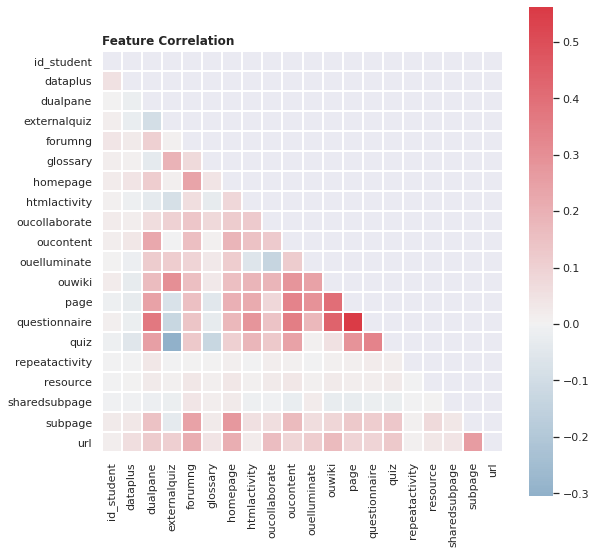

In [25]:
fig, ax = plt.subplots(figsize=(9 , 9))

corr = click_data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True



sns.heatmap(corr,
        square=True, center=0, linewidth=0.2,
        cmap=sns.diverging_palette(240, 10, as_cmap=True),
        mask=mask, ax=ax) 

ax.set_title('Feature Correlation', loc='left', fontweight='bold')
plt.show()

In [26]:
# merge score_df and click_df
def create_final_df(withdraw_deadline, score_df, click_df):

    final_df = inner_merge(click_df, # merge with StudentInfo
                           data_dicts['studentInfo'],
                           data_dicts['studentInfo'].columns,
                           ['code_module', 'code_presentation', 'id_student'],
                          )
    

    final_df = inner_merge(final_df, 
                           data_dicts['studentRegistration'],
                           ['code_module', 'code_presentation', 'id_student', 'date_unregistration'],
                           ['code_module', 'code_presentation', 'id_student'],
                          )

    final_df = final_df[(final_df['final_result'] != 'Withdrawn') | # remove people who withdrew before withdraw_deadline
                       (final_df['date_unregistration'] > withdraw_deadline)]

    final_df = final_df.reset_index()

    final_df = final_df.drop(['date_unregistration','index'],axis = 1)

    final_df = inner_merge(final_df,
                           score_df,
                           score_df.columns,
                           ['code_module', 'code_presentation', 'id_student'])
    
    final_df = final_df.replace('Distinction','Pass') # merge Pass and Distinction
    final_df = final_df.replace('Withdrawn','Fail') # merge Withdrawn to Fail

    return final_df

In [27]:
score_df = create_score_df(score_deadline)
click_df = create_click_df(click_deadline)
final_df = create_final_df(withdraw_deadline, score_df, click_df)
final_df

,code_module,code_presentation,id_student,dataplus,dualpane,externalquiz,forumng,glossary,homepage,htmlactivity,oucollaborate,oucontent,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,mean_score_day120
0,AAA,2013J,11391,0.0,0.0,0.0,3.641026,0.0,3.500000,0.0,0.0,9.805556,0.0,0.0,0.0,0.0,0.000000,0,1.250000,0.0,3.375000,1.000000,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,81.000000
1,AAA,2013J,28400,0.0,0.0,0.0,2.891089,0.0,4.586957,0.0,0.0,4.981818,0.0,0.0,0.0,0.0,0.000000,0,1.000000,0.0,2.266667,1.809524,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,69.333333
2,AAA,2013J,31604,0.0,0.0,0.0,3.037037,1.0,4.058824,0.0,0.0,4.784314,0.0,0.0,0.0,0.0,0.000000,0,1.571429,0.0,1.870370,1.757576,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,72.333333
3,AAA,2013J,32885,0.0,0.0,0.0,3.083333,2.0,3.605263,0.0,0.0,5.253521,0.0,0.0,0.0,0.0,0.000000,0,2.583333,0.0,1.636364,1.200000,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,54.000000
4,AAA,2013J,38053,7.0,0.0,0.0,3.364238,0.0,4.267606,0.0,0.0,4.218391,0.0,0.0,0.0,0.0,0.000000,0,1.400000,0.0,1.709677,1.375000,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,74.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23093,GGG,2014J,2606765,0.0,0.0,0.0,0.000000,1.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0,1.000000,0.0,1.000000,0.000000,F,London Region,Lower Than A Level,80-90%,0-35,0,30,N,Pass,55.000000
23094,GGG,2014J,2620947,0.0,0.0,0.0,3.500000,0.0,3.125000,0.0,0.0,2.560000,0.0,0.0,0.0,0.0,2.500000,0,1.125000,0.0,1.300000,0.000000,F,Scotland,A Level or Equivalent,80-90%,0-35,0,30,Y,Pass,80.000000
23095,GGG,2014J,2645731,0.0,0.0,0.0,1.000000,1.0,8.571429,0.0,0.0,4.736842,0.0,0.0,0.0,0.0,7.200000,0,1.533333,0.0,3.000000,0.000000,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Pass,80.000000
23096,GGG,2014J,2648187,0.0,0.0,0.0,0.000000,1.0,2.888889,0.0,0.0,3.714286,0.0,0.0,0.0,0.0,2.125000,0,1.400000,0.0,1.307692,0.000000,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,65.000000


# Modeling 

In [28]:
final_df['final_result'].value_counts()

Pass    15329
Fail     7769
Name: final_result, dtype: int64

In [29]:
def preprocessing(data):
    target=data['final_result']
    data = data.drop(['final_result','id_student','imd_band','code_module','code_presentation'],axis = 1)
    column_names = data.columns
    feature_n=data.select_dtypes(include=np.number).columns.tolist()
    feature_oh=['region','highest_education']
    features_la = ['gender','age_band','disability']
    
    
    def one_hot_encoder_one(data,feature):

        oh = OneHotEncoder()

        oh_df = pd.DataFrame(oh.fit_transform(data[feature]).toarray())
        oh_df.columns = oh.get_feature_names()

        new_data = pd.concat([data,oh_df],axis=1)
        new_data.drop(feature,axis=1,inplace=True)

        return new_data

    def ordinal_encoder(data,feature):
        le = LabelEncoder()
        encode_dict = {}

        for cat_feature in feature: 
            data[cat_feature] = le.fit_transform(data[cat_feature])
            encode_dict[cat_feature] = le.classes_
        return data,encode_dict
    
    sc=StandardScaler()
    data[feature_n]=sc.fit_transform(data[feature_n])
    data,encode_dict=ordinal_encoder(data,features_la)
    data=one_hot_encoder_one(data,feature_oh)
    
    return data,target,encode_dict,sc
        


In [30]:
df,target,encode_dict,sc=preprocessing(final_df)
df

,dataplus,dualpane,externalquiz,forumng,glossary,homepage,htmlactivity,oucollaborate,oucontent,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url,gender,age_band,num_of_prev_attempts,studied_credits,disability,mean_score_day120,x0_East Anglian Region,x0_East Midlands Region,x0_Ireland,x0_London Region,x0_North Region,x0_North Western Region,x0_Scotland,x0_South East Region,x0_South Region,x0_South West Region,x0_Wales,x0_West Midlands Region,x0_Yorkshire Region,x1_A Level or Equivalent,x1_HE Qualification,x1_Lower Than A Level,x1_No Formal quals,x1_Post Graduate Qualification
0,-0.070936,-0.300416,-0.347504,0.426556,-0.299355,-0.145318,-0.239619,-0.604131,1.970534,-0.261749,-0.583487,-0.537345,-0.40285,-0.966899,-0.007979,-0.013761,-0.061451,2.836244,-0.153096,1,2,-0.329446,4.442315,0,0.423077,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.070936,-0.300416,-0.347504,-0.008792,-0.299355,0.399150,-0.239619,-0.604131,0.314798,-0.261749,-0.583487,-0.537345,-0.40285,-0.966899,-0.007979,-0.102904,-0.061451,0.970992,1.216147,0,1,-0.329446,-0.412566,0,-0.326516,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.070936,-0.300416,-0.347504,0.075933,0.161520,0.134603,-0.239619,-0.604131,0.247005,-0.261749,-0.583487,-0.537345,-0.40285,-0.966899,-0.007979,0.100851,-0.061451,0.304051,1.128282,0,1,-0.329446,-0.412566,0,-0.133764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.070936,-0.300416,-0.347504,0.102808,0.622395,-0.092591,-0.239619,-0.604131,0.408059,-0.261749,-0.583487,-0.537345,-0.40285,-0.966899,-0.007979,0.461665,-0.061451,-0.089767,0.185188,0,0,-0.329446,-0.412566,0,-1.311696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,20.237098,-0.300416,-0.347504,0.265877,-0.299355,0.239184,-0.239619,-0.604131,0.052753,-0.261749,-0.583487,-0.537345,-0.40285,-0.966899,-0.007979,0.039724,-0.061451,0.033616,0.481186,1,1,-0.329446,-0.412566,0,-0.026679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23093,-0.070936,-0.300416,-0.347504,-1.687107,0.161520,-1.397597,-0.239619,-0.604131,-1.395199,-0.261749,-0.583487,-0.537345,-0.40285,-0.966899,-0.007979,-0.102904,-0.061451,-1.160725,-1.844514,0,0,-0.329446,-1.221713,0,-1.247446,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23094,-0.070936,-0.300416,-0.347504,0.344689,-0.299355,-0.333160,-0.239619,-0.604131,-0.516485,-0.261749,-0.583487,-0.537345,-0.40285,-0.560439,-0.007979,-0.058332,-0.061451,-0.655845,-1.844514,0,0,-0.329446,-1.221713,1,0.358827,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
23095,-0.070936,-0.300416,-0.347504,-1.106594,0.161520,2.395018,-0.239619,-0.604131,0.230710,-0.261749,-0.583487,-0.537345,-0.40285,0.203708,-0.007979,0.087267,-0.061451,2.205144,-1.844514,0,1,-0.329446,-1.221713,0,0.358827,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23096,-0.070936,-0.300416,-0.347504,-1.687107,0.161520,-0.451431,-0.239619,-0.604131,-0.120280,-0.261749,-0.583487,-0.537345,-0.40285,-0.621408,-0.007979,0.039724,-0.061451,-0.642899,-1.844514,0,0,-0.329446,-1.221713,1,-0.604937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [31]:
from sklearn.feature_selection import VarianceThreshold

# Create a VarianceThreshold instance with a threshold of 0.25
var_thr = VarianceThreshold(threshold=0.25)  # You can adjust the threshold as needed

# Fit the VarianceThreshold to the data
var_thr.fit(df)

# Get the support (boolean mask) for the selected features
var_thr.get_support()

# Identify the constant and quasi-constant columns
con_cols = [col for col in df.columns if col not in df.columns[var_thr.get_support()]]

# Drop the constant and quasi-constant columns from the dataset
df = df.drop(con_cols, axis=1)
df

,dataplus,dualpane,externalquiz,forumng,glossary,homepage,htmlactivity,oucollaborate,oucontent,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url,num_of_prev_attempts,studied_credits,mean_score_day120
0,-0.070936,-0.300416,-0.347504,0.426556,-0.299355,-0.145318,-0.239619,-0.604131,1.970534,-0.261749,-0.583487,-0.537345,-0.40285,-0.966899,-0.007979,-0.013761,-0.061451,2.836244,-0.153096,-0.329446,4.442315,0.423077
1,-0.070936,-0.300416,-0.347504,-0.008792,-0.299355,0.399150,-0.239619,-0.604131,0.314798,-0.261749,-0.583487,-0.537345,-0.40285,-0.966899,-0.007979,-0.102904,-0.061451,0.970992,1.216147,-0.329446,-0.412566,-0.326516
2,-0.070936,-0.300416,-0.347504,0.075933,0.161520,0.134603,-0.239619,-0.604131,0.247005,-0.261749,-0.583487,-0.537345,-0.40285,-0.966899,-0.007979,0.100851,-0.061451,0.304051,1.128282,-0.329446,-0.412566,-0.133764
3,-0.070936,-0.300416,-0.347504,0.102808,0.622395,-0.092591,-0.239619,-0.604131,0.408059,-0.261749,-0.583487,-0.537345,-0.40285,-0.966899,-0.007979,0.461665,-0.061451,-0.089767,0.185188,-0.329446,-0.412566,-1.311696
4,20.237098,-0.300416,-0.347504,0.265877,-0.299355,0.239184,-0.239619,-0.604131,0.052753,-0.261749,-0.583487,-0.537345,-0.40285,-0.966899,-0.007979,0.039724,-0.061451,0.033616,0.481186,-0.329446,-0.412566,-0.026679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23093,-0.070936,-0.300416,-0.347504,-1.687107,0.161520,-1.397597,-0.239619,-0.604131,-1.395199,-0.261749,-0.583487,-0.537345,-0.40285,-0.966899,-0.007979,-0.102904,-0.061451,-1.160725,-1.844514,-0.329446,-1.221713,-1.247446
23094,-0.070936,-0.300416,-0.347504,0.344689,-0.299355,-0.333160,-0.239619,-0.604131,-0.516485,-0.261749,-0.583487,-0.537345,-0.40285,-0.560439,-0.007979,-0.058332,-0.061451,-0.655845,-1.844514,-0.329446,-1.221713,0.358827
23095,-0.070936,-0.300416,-0.347504,-1.106594,0.161520,2.395018,-0.239619,-0.604131,0.230710,-0.261749,-0.583487,-0.537345,-0.40285,0.203708,-0.007979,0.087267,-0.061451,2.205144,-1.844514,-0.329446,-1.221713,0.358827
23096,-0.070936,-0.300416,-0.347504,-1.687107,0.161520,-0.451431,-0.239619,-0.604131,-0.120280,-0.261749,-0.583487,-0.537345,-0.40285,-0.621408,-0.007979,0.039724,-0.061451,-0.642899,-1.844514,-0.329446,-1.221713,-0.604937


In [32]:
from sklearn.decomposition import PCA


# Apply PCA
pca = PCA()
pca.fit(df)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components to retain 95% of the variance
num_components = np.argmax(cumulative_variance >= 0.95) + 1

# Perform PCA with the selected number of components
pca = PCA(n_components=num_components)
transformed_data = pca.fit_transform(df)

# Print the results
print(f"Original data shape: {data.shape}")
print(f"Transformed data shape: {transformed_data.shape}")
print(f"Number of components to retain 95% of the variance: {num_components}")

# You can use 'transformed_data' for further analysis or modeling


Original data shape: (25724, 4)
Transformed data shape: (23098, 20)
Number of components to retain 95% of the variance: 20


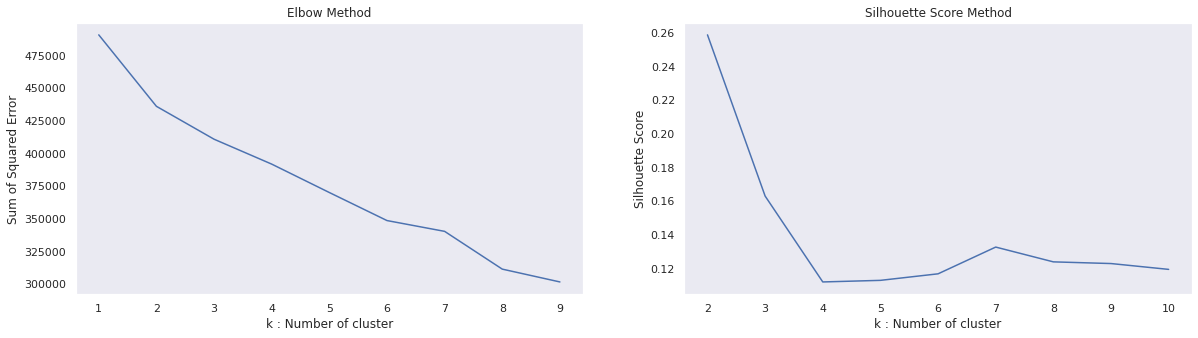

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(transformed_data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.grid()

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(transformed_data)
    labels = kmeans.labels_
    sil.append(silhouette_score(transformed_data, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.grid()

plt.show()

data without pca

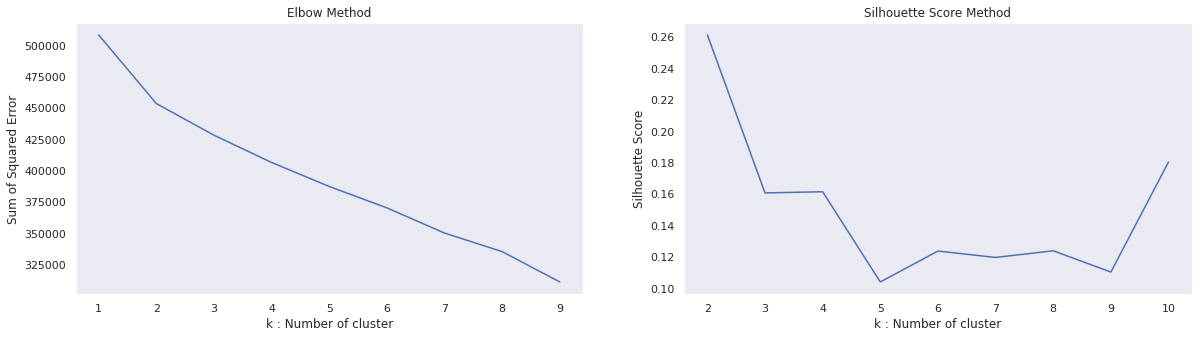

In [34]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.grid()

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(df)
    labels = kmeans.labels_
    sil.append(silhouette_score(df, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.grid()

plt.show()

In [35]:

from sklearn.metrics import adjusted_rand_score

# Perform K-means clustering
kmeans = KMeans(n_clusters=2)  # Assuming 2 clusters as the same 3 levels
predicted_labels = kmeans.fit_predict(df)

# Calculate the Rand Index
rand_index = adjusted_rand_score(target, predicted_labels)

print(f"Rand Index: {rand_index}")

Rand Index: -0.02103749053095166


In [36]:
predicted_labels,target

(array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 0        Pass
 1        Pass
 2        Pass
 3        Pass
 4        Pass
          ... 
 23093    Pass
 23094    Pass
 23095    Pass
 23096    Pass
 23097    Pass
 Name: final_result, Length: 23098, dtype: object)

In [37]:
target=target.replace({'Pass':1,'Fail':0})


In [38]:
from sklearn.metrics import f1_score
f1_score(predicted_labels,target)

0.333737496210973

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt



# Evaluate the model
accuracy = accuracy_score(target, predicted_labels)
precision = precision_score(target, predicted_labels)
recall = recall_score(target, predicted_labels)
f1 = f1_score(target, predicted_labels)

# Confusion Matrix
conf_matrix = confusion_matrix(target, predicted_labels)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")



Accuracy: 0.4290
Precision: 0.7398
Recall: 0.2155
F1 Score: 0.3337
Confusion Matrix:
[[ 6607  1162]
 [12026  3303]]


In [40]:
rand_index = adjusted_rand_score(target, predicted_labels)

print(f"Rand Index: {rand_index}")

Rand Index: -0.02103749053095166


In [41]:
np.array(np.unique(predicted_labels, return_counts=True)).T,target.value_counts()

(array([[    0, 18633],
        [    1,  4465]]),
 1    15329
 0     7769
 Name: final_result, dtype: int64)

In [42]:

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Apply DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=2)
y_pred = dbscan.fit_predict(df)


# Evaluate the DBSCAN results
silhouette = silhouette_score(df, y_pred)
ari = adjusted_rand_score(target, y_pred)

print(f"Silhouette Score: {silhouette:.4f}")
print(f"Adjusted Rand Index: {ari:.4f}")


Silhouette Score: -0.4397
Adjusted Rand Index: 0.0023


In [43]:
from sklearn.cluster import OPTICS, Birch, MeanShift


# Apply OPTICS clustering
optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.1)
optics_pred = optics.fit_predict(df)

# Apply Birch clustering
birch = Birch(threshold=0.5, n_clusters=2)
birch_pred = birch.fit_predict(df)

# Apply Mean Shift clustering
mean_shift = MeanShift(bandwidth=0.7)
mean_shift_pred = mean_shift.fit_predict(df)




# Evaluate the clustering algorithms
silhouette_optics = silhouette_score(df, optics_pred)
ari_optics = adjusted_rand_score(target, optics_pred)

silhouette_birch = silhouette_score(df, birch_pred)
ari_birch = adjusted_rand_score(target, birch_pred)

silhouette_mean_shift = silhouette_score(df, mean_shift_pred)
ari_mean_shift = adjusted_rand_score(target, mean_shift_pred)

# Print evaluation metrics
print("OPTICS:")
print(f"Silhouette Score: {silhouette_optics:.4f}")
print(f"Adjusted Rand Index: {ari_optics:.4f}")
print("\nBirch:")
print(f"Silhouette Score: {silhouette_birch:.4f}")
print(f"Adjusted Rand Index: {ari_birch:.4f}")
print("\nMean Shift:")
print(f"Silhouette Score: {silhouette_mean_shift:.4f}")
print(f"Adjusted Rand Index: {ari_mean_shift:.4f}")


OPTICS:
Silhouette Score: 0.7250
Adjusted Rand Index: 0.0004

Birch:
Silhouette Score: 0.2364
Adjusted Rand Index: -0.0260

Mean Shift:
Silhouette Score: 0.0289
Adjusted Rand Index: 0.0000


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import  AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score


# Apply Agglomerative Hierarchical Clustering
agg_clustering = AgglomerativeClustering(n_clusters=2)
agg_pred = agg_clustering.fit_predict(df)

# Apply Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_pred = gmm.fit_predict(df)



silhouette_agg = silhouette_score(df, agg_pred)
ari_agg = adjusted_rand_score(target, agg_pred)

silhouette_gmm = silhouette_score(df, gmm_pred)
ari_gmm = adjusted_rand_score(target, gmm_pred)


print("\nAgglomerative Hierarchical Clustering:")
print(f"Silhouette Score: {silhouette_agg:.4f}")
print(f"Adjusted Rand Index: {ari_agg:.4f}")
print("\nGaussian Mixture Model:")
print(f"Silhouette Score: {silhouette_gmm:.4f}")
print(f"Adjusted Rand Index: {ari_gmm:.4f}")



Agglomerative Hierarchical Clustering:
Silhouette Score: 0.2373
Adjusted Rand Index: -0.0245

Gaussian Mixture Model:
Silhouette Score: 0.2052
Adjusted Rand Index: -0.0237


# clusters Analysis

In [45]:

# Fit OPTICS model
optics_model = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.1)
optics_model.fit(df)

# Extract cluster labels
labels = optics_model.labels_

# # Visualize the clusters
# core_samples_mask = np.zeros_like(optics_model.labels_, dtype=bool)
# core_samples_mask[optics_model.core_sample_indices_] = True

# unique_labels = set(labels)
# colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         col = [0, 0, 0, 1]

#     class_member_mask = (labels == k)

#     # For visualization, considering the first two columns for x and y
#     xy = data_scaled[class_member_mask & core_samples_mask, -2:]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

#     xy = data_scaled[class_member_mask & ~core_samples_mask, :2]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

# plt.title('OPTICS Clustering')
# plt.show()


In [46]:
df_clusters=df.copy()
df_clusters = sc.inverse_transform(df_clusters)
df_clusters=pd.DataFrame(df_clusters,columns=df.columns)
df_clusters['clusters']=labels
df_clusters

,dataplus,dualpane,externalquiz,forumng,glossary,homepage,htmlactivity,oucollaborate,oucontent,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url,num_of_prev_attempts,studied_credits,mean_score_day120,clusters
0,0.0,0.0,0.0,3.641026,0.0,3.500000,0.0,0.0,9.805556,0.0,0.0,0.0,-2.775558e-17,0.000000,-2.710505e-20,1.250000,0.0,3.375000,1.000000,0.0,240.0,81.000000,0
1,0.0,0.0,0.0,2.891089,0.0,4.586957,0.0,0.0,4.981818,0.0,0.0,0.0,-2.775558e-17,0.000000,-2.710505e-20,1.000000,0.0,2.266667,1.809524,0.0,60.0,69.333333,0
2,0.0,0.0,0.0,3.037037,1.0,4.058824,0.0,0.0,4.784314,0.0,0.0,0.0,-2.775558e-17,0.000000,-2.710505e-20,1.571429,0.0,1.870370,1.757576,0.0,60.0,72.333333,0
3,0.0,0.0,0.0,3.083333,2.0,3.605263,0.0,0.0,5.253521,0.0,0.0,0.0,-2.775558e-17,0.000000,-2.710505e-20,2.583333,0.0,1.636364,1.200000,0.0,60.0,54.000000,0
4,7.0,0.0,0.0,3.364238,0.0,4.267606,0.0,0.0,4.218391,0.0,0.0,0.0,-2.775558e-17,0.000000,-2.710505e-20,1.400000,0.0,1.709677,1.375000,0.0,60.0,74.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23093,0.0,0.0,0.0,0.000000,1.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,-2.775558e-17,0.000000,-2.710505e-20,1.000000,0.0,1.000000,0.000000,0.0,30.0,55.000000,0
23094,0.0,0.0,0.0,3.500000,0.0,3.125000,0.0,0.0,2.560000,0.0,0.0,0.0,-2.775558e-17,2.500000,-2.710505e-20,1.125000,0.0,1.300000,0.000000,0.0,30.0,80.000000,0
23095,0.0,0.0,0.0,1.000000,1.0,8.571429,0.0,0.0,4.736842,0.0,0.0,0.0,-2.775558e-17,7.200000,-2.710505e-20,1.533333,0.0,3.000000,0.000000,0.0,30.0,80.000000,0
23096,0.0,0.0,0.0,0.000000,1.0,2.888889,0.0,0.0,3.714286,0.0,0.0,0.0,-2.775558e-17,2.125000,-2.710505e-20,1.400000,0.0,1.307692,0.000000,0.0,30.0,65.000000,0


<AxesSubplot:xlabel='clusters', ylabel='mean_score_day120'>

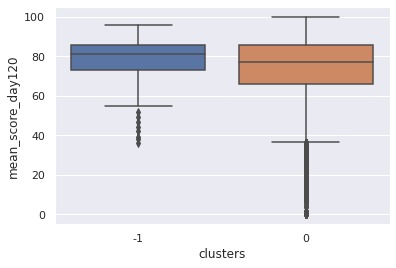

In [47]:
sns.boxplot(data=df_clusters,y='mean_score_day120',x='clusters')

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


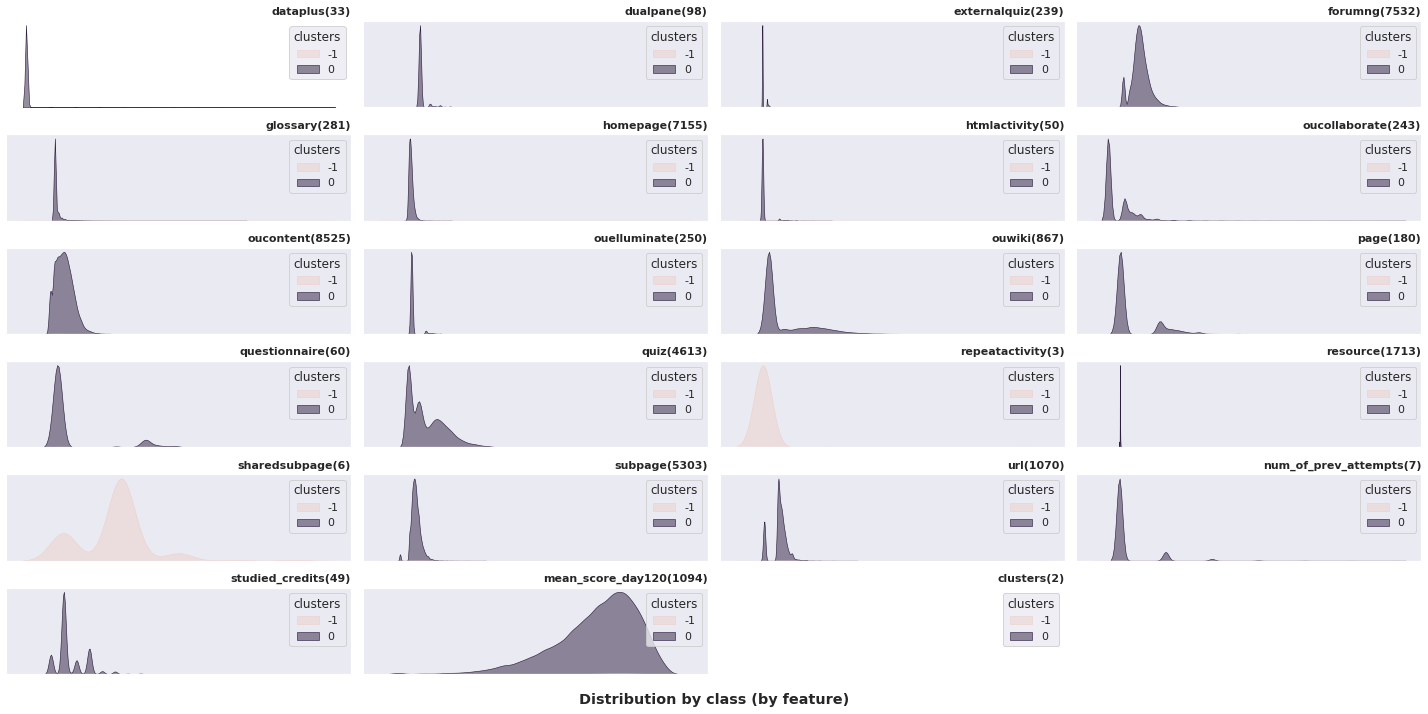

In [48]:
fig, axes = plt.subplots(6, 4, figsize=(20, 10))

target_order = sorted(df_clusters['clusters'].unique())
for column ,ax in zip(df_clusters,axes.flatten()):
    cnt = df_clusters[column].value_counts().sort_index()
    sns.kdeplot(x=column, 
                hue='clusters', hue_order=target_order,
                data=df_clusters,
                alpha=0.5, 
                linewidth=0.6, fill=True,
                legend=True,
                ax=ax,)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['left'].set_visible(False)
    cnt = len(df_clusters[column].unique())
    ax.set_title(f'{column}({cnt})', loc='right', weight='bold', fontsize=11)
    
axes.flatten()[0].axis('off') 
axes.flatten()[-1].axis('off')    
axes.flatten()[-2].axis('off') 
fig.supxlabel('Distribution by class (by feature)', ha='center', fontweight='bold')

fig.tight_layout()
plt.show()